# What is this notebook about
This notebook is meant to be run first, to explore the dataset

> Please ensure you have downloaded the necessary data first from the <a href="https://spacenet.ai/sn6-challenge/">SpaceNet 6 Website</a>. Only download the training data!

# Setup and Imports

In [64]:
import os
from pathlib import Path
import numpy as np
from matplotlib import pyplot as plt

import fiona
import rasterio
from rasterio.plot import show as show_raster, reshape_as_raster, reshape_as_image

# Global Variables

In [26]:
ROOT_DIR = Path('')
PATH_DATA_FULL = ROOT_DIR/'data_full/AOI_11_Rotterdam'

In [4]:
# An index, used just for inspecting one specific file
INSPECT_IDX = 0

# Helper Functions

### inspect_tif(tif_file)
Used to check out the basic features of a given tif file

In [5]:
def inspect_tif(tif_file):
    print("Count: {}".format(tif_file.count))

    # check the geospatial boundary of this image file, the corners of the image
    print("Corners: {}".format(tif_file.bounds))

    # getting dimensions, in map units of meters
    width = tif_file.bounds.right - tif_file.bounds.left
    height = tif_file.bounds.top - tif_file.bounds.bottom
    print("Width: {}, Height: {}".format(width, height))

    # getting pixel dimensions
    width_px = tif_file.width
    height_px = tif_file.height
    print("Pixels - Width: {}, Height: {}".format(width_px, height_px))

    # how many meters to a pixel
    width_ratio = width/width_px
    height_ratio = height/height_px
    print("m to px Ratio - Width: {}, Height: {}".format(width_ratio, height_ratio))

    # get coordinate reference system
    print("Coordinate Reference System: {}".format(tif_file.crs))

    # Get coordinates of top left and bottom right points since there is a coordinate reference system attached to this file
    topleft = tif_file.transform * (0,0)
    bottomright = tif_file.transform * (width, height)

    print("Top left coordinates: {}, Bottom right coordinates: {}".format(topleft, bottomright))

    # get basic metadata of this geotif file
    print("Metadata of geotiff file")
    print(tif_file.meta)     # can also use satdat.profile instead of satdat.meta

    # get number of bands by listing indices. count in the metadata refers to the number of bands
    print("Indexes: {}".format(tif_file.indexes))

### plot_bands(raster)
Plots out the individual bands of a raster file

In [62]:
def plot_bands(raster):
    channels = raster.read().shape[0]
    
    # PAN
    if channels == 1:
        show_raster(raster)
    
    # RGB
    elif channels == 3:
        fig, (axr, axg, axb) = plt.subplots(1,3, figsize=(21,7))
        show_raster((raster, 1), ax=axr, cmap='Reds', title='red channel')
        show_raster((raster, 2), ax=axg, cmap='Greens', title='green channel')
        show_raster((raster, 3), ax=axb, cmap='Blues', title='blue channel')
        plt.show()
    
    # Multispectral
    elif channels == 4:
        fig, (ax1, ax2, ax3, ax4) = plt.subplots(1,4, figsize=(21,7))
        show_raster((raster, 1), ax=ax1, cmap='Reds', title='channel 1')
        show_raster((raster, 2), ax=ax2, cmap='Greens', title='channel 2')
        show_raster((raster, 3), ax=ax3, cmap='Blues', title='channel 3')
        show_raster((raster, 4), ax=ax4, cmap='Oranges', title='channel 4')
        plt.show()      
        
    else:
        print("Wrong format")

# Data Inspection

<b>Key Terminologies</b>

There are several key terminologies that we will need

* geojson
    * geojson files contain spatial information about a picture, since as latitude, longitude, spatial dimensions, camera angle etc., and can also contain polygon data that are used to draw a mask over certain areas in the image 
* PAN
    * These refer to Panchromatic images, which are images that have only one band typically represented in greyscale. These are images captured using the entirety of the EM spectrum, which effectively captures the absolute intensity of light. Hence they are very high resolution images that have a great level of detail
* RGB
    * These refer to Red-Green-Blue images, which is the typical optical image that we have in our day-to-day life. They only use the visible spectrum of light
* RGBNIR
    * Includes standard RGB and a fourth channel for near-infrared wavelengths
* SAR-Intensity
    * Uses Synthetic Aperture Radar, with waves in polarisations of HH, VV, HV, VH (H for horizontal, V for vertical)
* PS / PanSharpen XXX
    * These refer to an amalgamation of PAN images with another image type (XXX) in order to enhance the resolution of other images while retaining their band-specific data

### Grab file names

In [32]:
PATH_GEOJSON = PATH_DATA_FULL/'geojson_buildings'
PATH_PAN = PATH_DATA_FULL/'PAN'
PATH_PSRGB = PATH_DATA_FULL/'PS-RGB'
PATH_PSRGBNIR = PATH_DATA_FULL/'PS-RGBNIR'
PATH_RGBNIR = PATH_DATA_FULL/'RGBNIR'
PATH_SAR = PATH_DATA_FULL/'SAR-Intensity'

fnames_geojson_buildings = next(os.walk(PATH_GEOJSON))[2]
fnames_pan = next(os.walk(PATH_PAN))[2]
fnames_psrgb = next(os.walk(PATH_PSRGB))[2]
fnames_psrgbnir = next(os.walk(PATH_PSRGBNIR))[2]
fnames_rgbnir = next(os.walk(PATH_RGBNIR))[2]
fnames_sar = next(os.walk(PATH_SAR))[2]


for fnames in [fnames_geojson_buildings, fnames_pan, fnames_rgbnir, fnames_sar, fnames_psrgb, fnames_psrgbnir]:
    fnames.sort()

fnames_psrgb[:3]

['SN6_Train_AOI_11_Rotterdam_PS-RGB_20190804111224_20190804111453_tile_8679.tif',
 'SN6_Train_AOI_11_Rotterdam_PS-RGB_20190804111224_20190804111453_tile_8681.tif',
 'SN6_Train_AOI_11_Rotterdam_PS-RGB_20190804111224_20190804111453_tile_8683.tif']

### Inspect geojson_buildings files

In [33]:
sample_geojson_buildings = fiona.open(PATH_GEOJSON/fnames_geojson_buildings[INSPECT_IDX]) 
for feature in sample_geojson_buildings: 
    print(feature)
    print("")

{'type': 'Feature', 'id': '0', 'properties': OrderedDict([('roof_075mean', 9.579999923706055), ('roof_075median', 9.579999923706055), ('roof_075stdev', 0.0), ('Building_ID', 25788), ('origarea', 335.7778938362906), ('origlen', 0), ('partialDec', 1.0), ('truncated', 0)]), 'geometry': {'type': 'Polygon', 'coordinates': [[(592407.3276001553, 5749547.382130783, 0.0), (592413.6648108196, 5749518.051389321, 0.0), (592402.8587757543, 5749515.791177336, 0.0), (592396.2202141188, 5749545.007996829, 0.0), (592407.3276001553, 5749547.382130783, 0.0)]]}}

{'type': 'Feature', 'id': '1', 'properties': OrderedDict([('roof_075mean', 8.90999984741211), ('roof_075median', 8.90999984741211), ('roof_075stdev', 0.0), ('Building_ID', 26135), ('origarea', 37.13761942357616), ('origlen', 0), ('partialDec', 1.0), ('truncated', 0)]), 'geometry': {'type': 'Polygon', 'coordinates': [[(592436.7797718926, 5749570.257214302, 0.0), (592446.5121082863, 5749572.407167605, 0.0), (592447.3116037531, 5749568.772324787, 0.

> We can see that every element in a geojson_buildings file represents a specific physical building 

In [34]:
sample_geojson_buildings[INSPECT_IDX]

{'type': 'Feature',
 'id': '0',
 'properties': OrderedDict([('roof_075mean', 9.579999923706055),
              ('roof_075median', 9.579999923706055),
              ('roof_075stdev', 0.0),
              ('Building_ID', 25788),
              ('origarea', 335.7778938362906),
              ('origlen', 0),
              ('partialDec', 1.0),
              ('truncated', 0)]),
 'geometry': {'type': 'Polygon',
  'coordinates': [[(592407.3276001553, 5749547.382130783, 0.0),
    (592413.6648108196, 5749518.051389321, 0.0),
    (592402.8587757543, 5749515.791177336, 0.0),
    (592396.2202141188, 5749545.007996829, 0.0),
    (592407.3276001553, 5749547.382130783, 0.0)]]}}

> The `geometry` property will allow us to create a segmentation mask over the original image

### Inspect PAN files

In [35]:
sample_pan = rasterio.open(PATH_PAN/fnames_pan[INSPECT_IDX]) 
inspect_tif(sample_pan)

Count: 1
Corners: BoundingBox(left=592318.6201042183, bottom=5749422.410443312, right=592768.6142138068, top=5749872.4045529)
Width: 449.9941095885588, Height: 449.9941095886752
Pixels - Width: 900, Height: 900
m to px Ratio - Width: 0.49999345509839865, Height: 0.499993455098528
Coordinate Reference System: EPSG:32631
Top left coordinates: (592318.6201042183, 5749872.4045529), Bottom right coordinates: (592543.6142138453, 5749647.410443273)
Metadata of geotiff file
{'driver': 'GTiff', 'dtype': 'uint16', 'nodata': 0.0, 'width': 900, 'height': 900, 'count': 1, 'crs': CRS.from_dict(init='epsg:32631'), 'transform': Affine(0.49999345509841014, 0.0, 592318.6201042183,
       0.0, -0.49999345509841014, 5749872.4045529)}
Indexes: (1,)


> We get a detailed print out of the information embedded in the tif file. We can see that the PAN images have 1 channel, as given by the `indexes` 
<br><br> Its resolution is 900x900 pixels

### Inspect RGBNIR files

In [36]:
sample_rgbnir = rasterio.open(PATH_RGBNIR/fnames_rgbnir[INSPECT_IDX])
inspect_tif(sample_rgbnir)

Count: 4
Corners: BoundingBox(left=592318.6201042183, bottom=5749422.382810882, right=592768.6418462361, top=5749872.4045529)
Width: 450.02174201782327, Height: 450.0217420179397
Pixels - Width: 450, Height: 450
m to px Ratio - Width: 1.0000483155951627, Height: 1.0000483155954216
Coordinate Reference System: EPSG:32631
Top left coordinates: (592318.6201042183, 5749872.4045529), Bottom right coordinates: (592768.6635893043, 5749422.361067814)
Metadata of geotiff file
{'driver': 'GTiff', 'dtype': 'uint16', 'nodata': 0.0, 'width': 450, 'height': 450, 'count': 4, 'crs': CRS.from_dict(init='epsg:32631'), 'transform': Affine(1.0000483155950517, 0.0, 592318.6201042183,
       0.0, -1.0000483155950517, 5749872.4045529)}
Indexes: (1, 2, 3, 4)


> Similarly, we get a print of the details for a RGBNIR image, which as we expect has 4 channels. <br>We also note the decreased pixel count - 450x450 for RGBNIR versus 900x900 for PAN

### Inspect PS-RGB files

In [37]:
sample_psrgb = rasterio.open(PATH_PSRGB/fnames_psrgb[INSPECT_IDX])
inspect_tif(sample_psrgb)

Count: 3
Corners: BoundingBox(left=592318.6201042183, bottom=5749422.407724249, right=592768.616932869, top=5749872.4045529)
Width: 449.99682865070645, Height: 449.9968286510557
Pixels - Width: 900, Height: 900
m to px Ratio - Width: 0.4999964762785627, Height: 0.4999964762789508
Coordinate Reference System: EPSG:32631
Top left coordinates: (592318.6201042183, 5749872.4045529), Bottom right coordinates: (592543.6169328801, 5749647.407724238)
Metadata of geotiff file
{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': 0.0, 'width': 900, 'height': 900, 'count': 3, 'crs': CRS.from_dict(init='epsg:32631'), 'transform': Affine(0.4999964762785847, 0.0, 592318.6201042183,
       0.0, -0.4999964762785847, 5749872.4045529)}
Indexes: (1, 2, 3)


> We see the PS-RGB channel has three channels by the three indexes, and also that it has a 900x900 resolution due to PAN sharpening

### Inspect PS-RGBNIR files

In [39]:
sample_psrgbnir = rasterio.open(PATH_PSRGBNIR/fnames_psrgbnir[INSPECT_IDX])
inspect_tif(sample_psrgbnir)

Count: 4
Corners: BoundingBox(left=592318.6201042183, bottom=5749422.4062604895, right=592768.6183966289, top=5749872.4045529)
Width: 449.9982924106298, Height: 449.9982924107462
Pixels - Width: 900, Height: 900
m to px Ratio - Width: 0.49999810267847755, Height: 0.4999981026786069
Coordinate Reference System: EPSG:32631
Top left coordinates: (592318.6201042183, 5749872.4045529), Bottom right coordinates: (592543.6183966321, 5749647.406260487)
Metadata of geotiff file
{'driver': 'GTiff', 'dtype': 'uint16', 'nodata': 0.0, 'width': 900, 'height': 900, 'count': 4, 'crs': CRS.from_dict(init='epsg:32631'), 'transform': Affine(0.49999810267850525, 0.0, 592318.6201042183,
       0.0, -0.49999810267850525, 5749872.4045529)}
Indexes: (1, 2, 3, 4)


> Similarly, PS-RGBNIR has 4 channels but a higher resolution 

### Inspect SAR-Intensity

In [40]:
sample_sar = rasterio.open(PATH_SAR/fnames_sar[INSPECT_IDX])
inspect_tif(sample_sar)

Count: 4
Corners: BoundingBox(left=592318.6201042183, bottom=5749422.4045529, right=592768.6201042183, top=5749872.4045529)
Width: 450.0, Height: 450.0
Pixels - Width: 900, Height: 900
m to px Ratio - Width: 0.5, Height: 0.5
Coordinate Reference System: EPSG:32631
Top left coordinates: (592318.6201042183, 5749872.4045529), Bottom right coordinates: (592543.6201042183, 5749647.4045529)
Metadata of geotiff file
{'driver': 'GTiff', 'dtype': 'float32', 'nodata': 0.0, 'width': 900, 'height': 900, 'count': 4, 'crs': CRS.from_dict(init='epsg:32631'), 'transform': Affine(0.5, 0.0, 592318.6201042183,
       0.0, -0.5, 5749872.4045529)}
Indexes: (1, 2, 3, 4)


> The key difference here is that SAR data is float32 whereas the rest are uint16 

# Let's take a peek at the images

### Notes about the tif files

In [42]:
print("Type of the file read by rasterio.open():", type(sample_psrgb))

print("Access raw image pixel values through: rasterfile.read()")

print("Type of the raw image pixel values:", type(sample_psrgb.read()))

print("Shape of the raw image pixel values:", sample_psrgb.read().shape)

Type of the file read by rasterio.open(): <class 'rasterio.io.DatasetReader'>
Access raw image pixel values through: rasterfile.read()
Type of the raw image pixel values: <class 'numpy.ndarray'>
Shape of the raw image pixel values: (3, 900, 900)


### Very important note
Pay attention to the shape of the pixels: it is in the format `(channels, height, width)`. However, RGB images are conventionally represented as `(height, width, channels)`

> Raster format: `(channels, height, width)`

> Normal format: `(height, width, channels)`

We need to remember to do reshaping in order to use conventional ML tools that are trained on regular images

### View an image
We have imported `show` from rasterio as `show_raster`. This is a wrapper on matplotlib that accepts a raster format of `(channels, height, width)` and plots it out.

##### Note - All of these are false-coloured images because they have datatypes of either uint16, or float32 (SAR), while normal RGB images are uint8

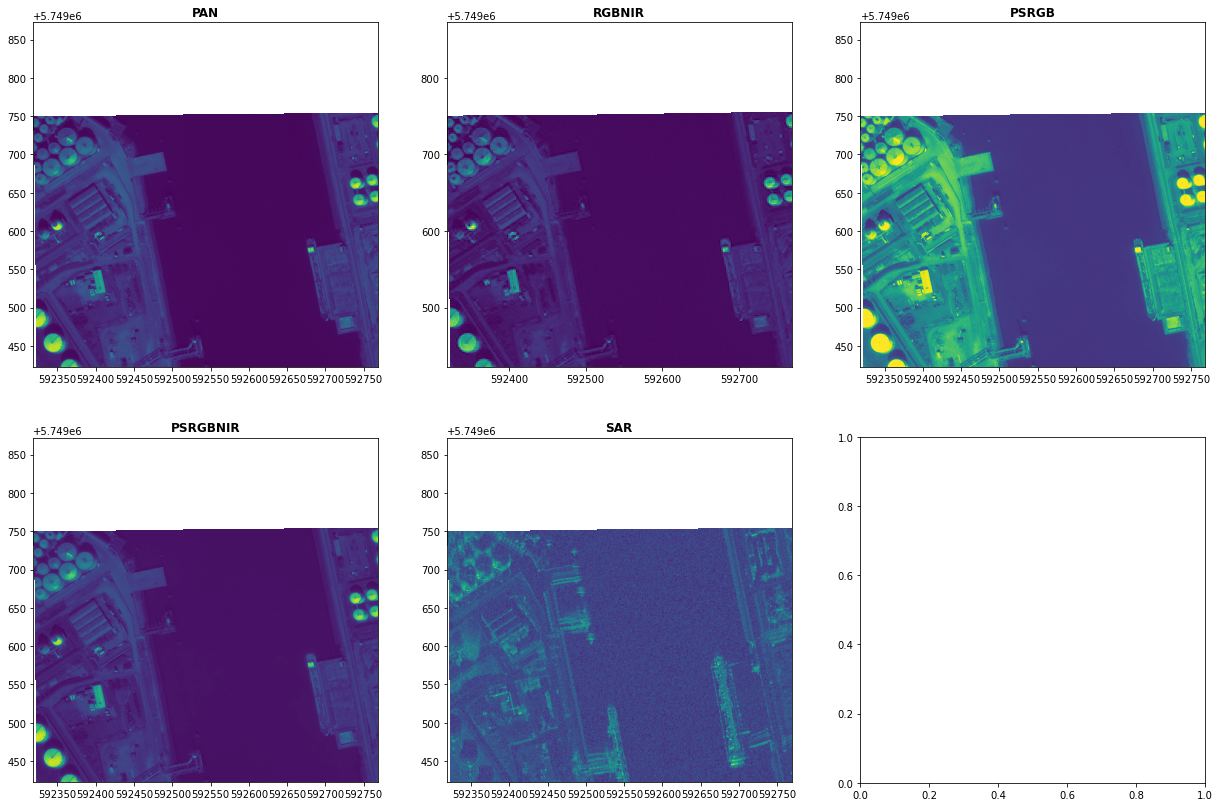

In [49]:
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2,3, figsize=(21,14))
show_raster(sample_pan, ax=ax1, title='PAN')
show_raster(sample_rgbnir, ax=ax2, title='RGBNIR')
show_raster(sample_psrgb, ax=ax3, title='PSRGB')
show_raster(sample_psrgbnir, ax=ax4, title='PSRGBNIR')
show_raster(sample_sar, ax=ax5, title='SAR')
plt.show()      

### Encompass raster plotting functionalities in a helper function plot_bands()

##### We can plot a PAN image

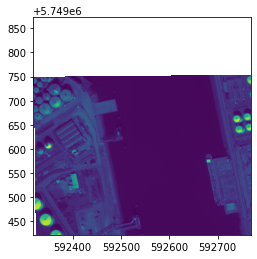

In [50]:
plot_bands(sample_pan)

##### We can unpack the individual channels of a RGB image

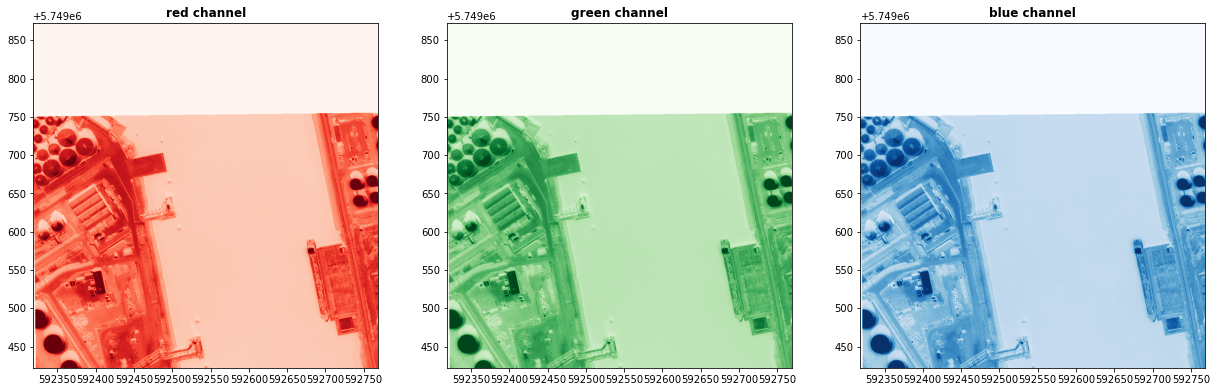

In [52]:
plot_bands(sample_psrgb)

##### We can also unpack SAR images

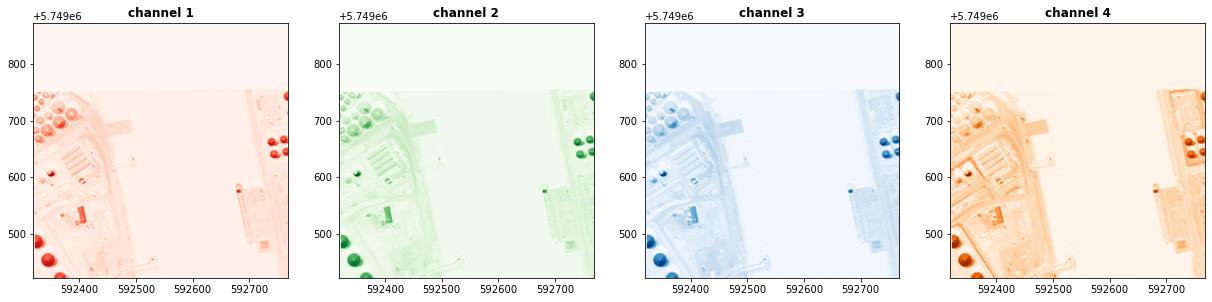

In [63]:
plot_bands(sample_rgbnir)

# We've inspected the data, now what?

We now need to generate the masks over the images. We shall do that in another notebook